In [1]:
import pandas as pd
import numpy
import pickle
import time
import joblib
import gensim
import matplotlib.pyplot as plt

from itertools import islice
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.corpora import Dictionary, bleicorpus
from gensim.matutils import hellinger
from gensim.models.coherencemodel import CoherenceModel

# Remove warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the dataset.
df = pd.read_pickle("/project/biocomplexity/sdad/projects_data/ncses/prd/Paper/FR_meta_and_final_tokens_23DEC21.pkl")
df.head()

# Compute the time variable
year = df['FY'].unique()
del df

path = '/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/nmf_fullabstract/'
n_topics = list(range(20,61,5))

## Comment: Run this section if not using slurm

In [ ]:

# Find topics that maximise the coherence for each windows
model = []
coherence = []
max_coherence = []
    
for fy in year:
    # upload the result that are necessary for the coherence
    topics_list = joblib.load( path+'nmf_out/windows_nmf'+str(fy)+'.pkl' )[1]
    docs = joblib.load( path+'Term_docs_'+str(fy)+'.pkl' )[2]
    dictionary = joblib.load( path+'Term_docs_'+str(fy)+'.pkl' )[3]
    
    for t in range(0,len(n_topics)):
        term_rankings = topics_list[t]
        cm = CoherenceModel(topics=term_rankings, dictionary=dictionary, texts=docs, coherence='c_v', topn=10, processes=1)
        
        # get the coherence value
        coherence.append(cm.get_coherence())
        print("one step")
    
    # find the topics that maximize the coherence
    max_value = numpy.nanmax(coherence)
    index = coherence.index(max_value)
    model.append(n_topics(index))
    max_coherence.append(max_value)
    print('------- solve for a year -------')
    
# Save the result from the first step
joblib.dump((model, max_coherence), path+'first_stage.pkl' )
    

## Comment: Run this section if using slurm

In [3]:
# compute the coherence form the first step. Take results from slurm
coherence = []
model = []
for fy in year:
    (fy_idx_model, fy_max_coherence) = joblib.load( path+'Coherence/model_'+str(fy)+'.pkl' )
    model.append(n_topics[fy_idx_model])
    coherence.append(fy_max_coherence)

# Save the result from the first step
joblib.dump((model, coherence), path+'first_stage.pkl' )

['/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/nmf_fullabstract/first_stage.pkl']

# - Result first stage

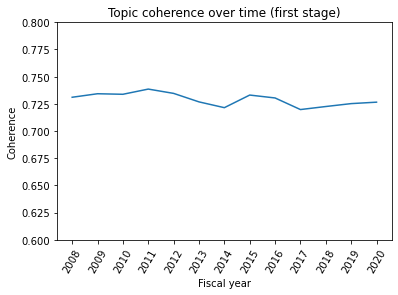

In [32]:
# Plot the coherence
coherence_windows = pd.Series(coherence, index =year)
plt.plot(coherence_windows)
plt.ylim(0.6, 0.8)
plt.xticks(rotation=60)
plt.title('Topic coherence over time (first stage)')
plt.xlabel("Fiscal year")
plt.ylabel("Coherence")
plt.savefig('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/nmf_fullabstract/Coherence/Coherence_first_stage.png')

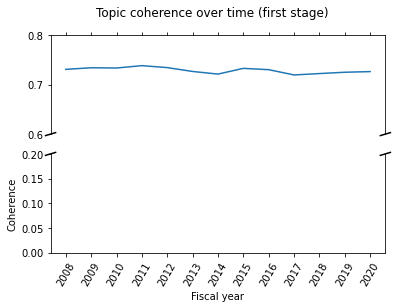

In [35]:
f, (ax, ax2) = plt.subplots(2, 1, sharex=True)

# plot the same data on both axes
ax.plot(coherence_windows)
ax2.plot(coherence_windows)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(.6, .8)  # outliers only
ax2.set_ylim(0, .2)  # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.xticks(rotation=60)
plt.suptitle('Topic coherence over time (first stage)')
plt.xlabel("Fiscal year")
plt.ylabel("Coherence")
plt.savefig('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/nmf_fullabstract/Coherence/Coherence_first_stage.png')
plt.show()

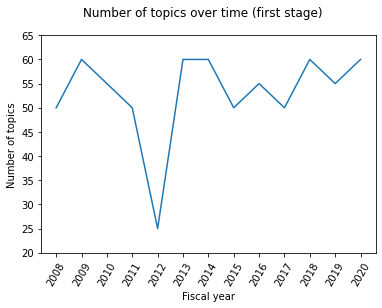

In [34]:
# Plot the model
model_windows = pd.Series(model, index =year)
plt.plot(model_windows)
plt.ylim(20, 65)
plt.xticks(rotation=60)
plt.suptitle('Number of topics over time (first stage)')
plt.xlabel("Fiscal year")
plt.ylabel("Number of topics")
plt.savefig('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/nmf_fullabstract/Coherence/model_first_stage.png')

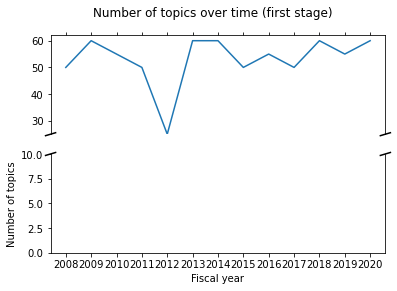

In [23]:
f, (ax, ax2) = plt.subplots(2, 1, sharex=True)

# plot the same data on both axes
ax.plot(model_windows)
ax2.plot(model_windows)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(25, 62)  # outliers only
ax2.set_ylim(0, 10)  # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.tick_top()
ax.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

d = .015  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

plt.suptitle('Number of topics over time (first stage)')
plt.xlabel("Fiscal year")
plt.ylabel("Number of topics")
plt.savefig('/project/biocomplexity/sdad/projects_data/ncses/prd/Dynamic_Topics_Modelling/nmf_fullabstract/Coherence/model_first_stage.png')

In [16]:
# Print topic from the first step
select_year = 2020

(nmf_time,topics_list,W_list,H_list) = joblib.load( path+'nmf_out/windows_nmf'+str(select_year)+'.pkl' )
(idx_model, max_coherence) = joblib.load( path+'Coherence/model_'+str(select_year)+'.pkl' )
fy_k = n_topics[idx_model]
fy_topic_list = topics_list[idx_model]
fy_topic_list

# Print the result
for i in range(0,len(fy_topic_list)):
    print(fy_topic_list[i])

['mouse', 'model', 'human', 'animal', 'disease', 'vivo', 'transgenic', 'tissue', 'study', 'mutation']
['training', 'program', 'trainee', 'faculty', 'mentor', 'career', 'year', 'scientist', 'train', 'science']
['health', 'community', 'disparity', 'public', 'population', 'policy', 'environmental', 'science', 'mental', 'engagement']
['cancer', 'prostate', 'nci', 'member', 'ovarian', 'pancreatic', 'oncology', 'program', 'programmatic', 'hpv']
['core', 'administrative', 'service', 'provide', 'investigator', 'support', 'facility', 'cores', 'ppg', 'spore']
['hiv', 'aids', 'art', 'infect', 'prep', 'prevention', 'infection', 'antiretroviral', 'cfar', 'reservoir']
['cognitive', 'memory', 'impairment', 'dementia', 'decline', 'cognition', 'alzheimer', 'deficit', 'function', 'measure']
['ad', 'tau', 'alzheimer', 'aβ', 'disease', 'amyloid', 'pathology', 'dementia', 'biomarker', 'adrd']
['cell', 'type', 'tissue', 'single', 'cd8', 'antigen', 'differentiation', 'cd4', 'stem', 'cellular']
['patient', 't